# Sentiment Analysis of Clusters of the Amazon Movie Reviews using K-means Clustering and VADER Lexicon

By Heidi Nguyen

<a id="top"></a>

# Table of Contents 

- [I. Load in Sentiment Analyzer](#analyzer)

- [II. Statistical Sentiment Values of Clusters](#stats)

- [III. **Summary of Results**](#resultHW8)

- [IV. Reference](#ref)


In [568]:
# libraries
from pandas import DataFrame,Series
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
from collections import Counter
import os # to set wd # # os.environ['KERAS_BACKEND']='tensorflow' for keras
import re

# get time stamp
import time
# import Image
from IPython.display import Image

# sklearn
from sklearn.metrics import roc_auc_score
from sklearn import metrics

# access keyboard shortcuts: Esc + H
# Mac: Cmd + Shift + P ==> private browsing => Firefox does not track 
# Linux and Windows: or Ctrl + Shift + P on Linux and Windows

# Set wd
path = "/Volumes/NO NAME/Data Science/2018-0826 MSDS 7337 Natural Language Processing/Unit 14/hw8"
os.chdir(path)
print (os.getcwd()); # Prints the working directory


/Volumes/NO NAME/Data Science/2018-0826 MSDS 7337 Natural Language Processing/Unit 14/hw8


## Software Used

In [625]:
import platform; print(platform.platform())
import sys; print("python", sys.version)
import numpy; print("numpy", numpy.__version__)
import scipy; print("scipy", scipy.__version__)
import sklearn; print("Scikit-learn", sklearn.__version__)
import pandas; print("Pandas", pandas.__version__)
import bokeh; print("bokeh", bokeh.__version__)
import seaborn as sns; print("seaborn", sns.__version__)
import matplotlib ; print("matplotlib", matplotlib.__version__)
import spacy; print("spacy", spacy.__version__)
import nltk; print("nltk", nltk.__version__)
# import yellowbrick; print("yellowbrick", yellowbrick.__version__)
import gensim; print("gensim", gensim.__version__)
# import mglearn; print("mglearn", mglearn.__version__)
import re; print("re", re.__version__)
import pattern; print("pattern", pattern.__version__)
# print os.environ['CONDA']

Darwin-18.0.0-x86_64-i386-64bit
('python', '2.7.14 |Anaconda custom (64-bit)| (default, Mar 27 2018, 12:28:59) \n[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]')
('numpy', '1.14.5')
('scipy', '1.1.0')
('Scikit-learn', '0.19.1')
('Pandas', u'0.23.3')
('bokeh', u'0.13.0')
('seaborn', '0.9.0')
('matplotlib', '2.2.3')
('spacy', '2.0.12')
('nltk', '3.3')
('gensim', '3.4.0')
('re', '2.2.1')
('pattern', '2.4')


<a id="analyzer"></a>

# Question 1: 

1. In Python, load one of the sentiment vocabularies referenced in the textbook, and run the sentiment analyzer as explained in the corresponding reference. Add words to the sentiment vocabulary, if you think you need to, to better fit your particular text collection.

 <a href="#top">Back to top</a>

In [569]:
from normalization_hn import normalize_corpus, normalize_accented_characters, strip_html, html_parser, pos_tag_text
# from normalization import normalize_accented_characters, html_parser, strip_html
from utils import build_feature_matrix

# from HTMLParser import HTMLParser
# html_parser = HTMLParser()

## VADER Lexicon

In [570]:
%%time 

# VADER Lexicon
from nltk.sentiment.vader import SentimentIntensityAnalyzer

def analyze_sentiment_vader_lexicon(review, 
                                    threshold=0.1,
                                    verbose=False):
    # pre-process text using normalize_corpus function within normalization_hn 
    review = normalize_accented_characters(review)
    review = html_parser.unescape(review)
    review = strip_html(review)
    # analyze the sentiment for review
    analyzer = SentimentIntensityAnalyzer()
    scores = analyzer.polarity_scores(review)
    # get aggregate scores and final sentiment
    agg_score = scores['compound']
    final_sentiment = 'positive' if agg_score >= threshold\
                                   else 'negative'
    if verbose:
        # display detailed sentiment statistics
        positive = str(round(scores['pos'], 2)*100)+'%'
        final = round(agg_score, 2)
        negative = str(round(scores['neg'], 2)*100)+'%'
        neutral = str(round(scores['neu'], 2)*100)+'%'
        sentiment_frame = pd.DataFrame([[final_sentiment, final, positive,
                                        negative, neutral]],
                                        columns=pd.MultiIndex(levels=[['VADER SENTIMENT STATS:'], 
                                                                      ['Predicted Sentiment', 'Polarity Score',
                                                                       'Positive', 'Negative',
                                                                       'Neutral']], 
                                                              labels=[[0,0,0,0,0],[0,1,2,3,4]]))
        print sentiment_frame
    
    return  agg_score# final_sentiment, 

CPU times: user 30 µs, sys: 2 µs, total: 32 µs
Wall time: 43.9 µs


That function helps in computing the sentiment and various statistics associated with it for any text document (movie reviews in our case). The comments explain the main sections of the function, which include text-preprocessing, getting the necessary sentiment scores using the VADER lexicon, aggregating them, and computing the final sentiment (positive/negative) using a specific threshold we talked about earlier. A threshold of 0.1 seemed to work best on an average. 

### Load in movie reviews data 

In [571]:
# coding: utf-8

# load movie reviews  
movie_data_all = pd.read_csv(r'reviews_movies_nodup_wTitle_clean4000_20181112-144157.csv') # must read in as r' if does not have encoding='utf-8'
movie_data_all.head()

# dataset = pd.read_csv(r'E:/aclImdb/movie_reviews.csv')
# # print sample data
# In [235]: print dataset.head()

,product_desc,body
0,Woman Walks Ahead,"Very good movie, sad tho as to what the white ..."
1,Woman Walks Ahead,I loved this film. True story about Sitting B...
2,Woman Walks Ahead,Excellent
3,Woman Walks Ahead,Good movie.
4,Woman Walks Ahead,True life happenings terrible for what happen...


In [572]:
# remame column names
movie_data_all = movie_data_all.rename(index=str, columns={"product_desc": "title", "body": "reviews"})
movie_data_all.head()

,title,reviews
0,Woman Walks Ahead,"Very good movie, sad tho as to what the white ..."
1,Woman Walks Ahead,I loved this film. True story about Sitting B...
2,Woman Walks Ahead,Excellent
3,Woman Walks Ahead,Good movie.
4,Woman Walks Ahead,True life happenings terrible for what happen...


In [573]:
# get a random subset without replacement
movie_data = movie_data_all.sample(n=300)
movie_data.info()
movie_data.head()
# movie_data_all['reviews'][0]

<class 'pandas.core.frame.DataFrame'>
Index: 300 entries, 570 to 6244
Data columns (total 2 columns):
title      300 non-null object
reviews    300 non-null object
dtypes: object(2)
memory usage: 7.0+ KB


,title,reviews
570,Jumanji: Welcome To The Jungle,"both my kids love this movie, it's pretty funn..."
3302,Galaxy Quest,I liked this movie and I thought it would be l...
14020,Galaxy Quest,Ranks up there as one of the best Sci Fi movie...
7320,Woman Walks Ahead,"Not a bad film, but not an accurate one either..."
7390,Into the Blue (2005),Loved the movie!


In [574]:
# get the np arrays of title and reviews 
movie_titles = np.array(movie_data['title'])
movie_reviews = np.array(movie_data['reviews'])


In [575]:
# print sample movie and its synopsis
print 'Movie:', movie_titles[49]
print 'Movie Review:', movie_reviews[49][:1000]


Movie: Get Smart
Movie Review: One of Steve Carell's best. The whole cast is terrific. This is a very enjoyable flick, and one that we look forward to viewing several times in the future.


In [576]:
# Analyze sentiment with VADER Lexicon

# example 
review = movie_reviews[49][:1000]
print 'Review:'
print review
print
final_sentiment = analyze_sentiment_vader_lexicon(review,
                                                  threshold=0.1,
                                               verbose=True)
print "final score:"
print final_sentiment


print '-'*60   


Review:
One of Steve Carell's best. The whole cast is terrific. This is a very enjoyable flick, and one that we look forward to viewing several times in the future.

  VADER SENTIMENT STATS:                                         
     Predicted Sentiment Polarity Score Positive Negative Neutral
0               positive           0.89    30.0%     0.0%   70.0%
final score:
0.8883
------------------------------------------------------------



<a id="stats"></a>

# Question 2: 

2. For each of the clusters you created in homework 7, compute the average, median, high, and low sentiment scores for each cluster. Explain whether you think this reveals anything interesting about the clusters.

 <a href="#top">Back to top</a>

## K-means Clustering
- I will cluster these movies into groups using their reviews as raw input.
- I will extract features from these reviews and use unsupervised learning algorithms on them to cluster them together. The movie titles are just for representation and will be useful when we would want to visualize and display clusters and their statistics. 
- The data to be fed to the clustering algorithms will be features extracted from the movie reviews just to make things clearer. 

#### Normalization

In [577]:
# coding: utf-8
# perform normalization and feature extraction. 
from normalization_hn import normalize_corpus
from utils import build_feature_matrix

# normalize corpus
norm_movie_reviews = normalize_corpus(movie_reviews,
                                       lemmatize=True,
                                       only_text_chars=True)

In [578]:
# norm_movie_reviews = normalize_corpus(norm_movie_reviews,
#                                        lemmatize=True,
#                                        only_text_chars=True)# 
norm_movie_reviews

[u'kid love movie pretty funny def not young kid',
 u'like movie think would lame humor silly humor would not laph laph lot not lame silly well sometimes silly never lame movie must',
 u'rank best sci fi movie',
 u'not bad film not accurate either would nice someone hollywood would use movie way inform audience prove fact instead brainwashing propaganda tool',
 u'love movie',
 u'movie entertain funny kid love would watch every day let',
 u'always good movie rainy day always love car not think enough word type meet minimum get',
 u'spoof sify fun watch watch cast play play line deli havered dead pan fun movei',
 u'awesome perfect everyone',
 u'great thanks',
 u'bad ever sylvester stallone movie',
 u'good action movie plenty suspense',
 u'pretty funny jack black doe great role kevin hart typical funny self not believe jock trap kevin hart body',
 u'nice water play',
 u'overall good plot clean action like link original jumanji robin wiliams',
 u'yuck nasty horrible scene nothing like firs

#### TF-IDF–based Feature Extraction

Keep text tokens in the normalized text and extract TF-IDF–based features only bigrams such that each feature occurs in at least in 0 percent of the documents and at most 50 percent of the documents using the terms min_df and max_df. 

In [579]:
# extract tf-idf features, including bigrams
vectorizer, feature_matrix = build_feature_matrix(norm_movie_reviews,
                                                  feature_type='tfidf',
                                                  min_df=0.00, max_df=.50, # min_df=0.24, max_df=0.85,
                                                  ngram_range=(1, 1)) # include only unigrams

In [580]:
# view number of features
print feature_matrix.shape

(300, 2346)


We can see that we have a total of 300 rows for the 300 movies reviews and a total of 2407 features for each movie. 

In [581]:
# get feature names
feature_names = vectorizer.get_feature_names()
# print sample features
print feature_names[:20]

[u'1970s', u'2nd', u'4k', u'80s', u'abandon', u'abiding', u'ability', u'able', u'aboard', u'abomination', u'abound', u'abrupt', u'absolute', u'absolutely', u'accept', u'accidentally', u'accompany', u'accompanying', u'accomplish', u'accross']


In [582]:
vectorizer.vocabulary_

{u'pardon': 1462,
 u'child': 332,
 u'suspenseful': 2030,
 u'hitch': 975,
 u'survi': 2026,
 u'scheming': 1767,
 u'bufford': 253,
 u'poorly': 1532,
 u'whose': 2290,
 u'edward': 621,
 u'rickman': 1706,
 u'lord': 1208,
 u'sorry': 1913,
 u'pride': 1556,
 u'worth': 2321,
 u'rescue': 1679,
 u'deli': 506,
 u'dispense': 559,
 u'every': 676,
 u'jack': 1085,
 u'frailty': 800,
 u'vastly': 2227,
 u'nephue': 1364,
 u'trailer': 2134,
 u'identity': 1018,
 u'four': 799,
 u'school': 1769,
 u'respecti': 1685,
 u'prize': 1566,
 u'red': 1647,
 u'enhance': 647,
 u'ups': 2217,
 u'clothes': 362,
 u'enjoy': 648,
 u'charter': 321,
 u'force': 788,
 u'speck': 1925,
 u'direct': 542,
 u'horn': 995,
 u'nail': 1342,
 u'crave': 442,
 u'street': 1977,
 u'follow': 785,
 u'jessica': 1093,
 u'blue': 212,
 u'hide': 963,
 u'wreck': 2327,
 u'ruthless': 1746,
 u'poison': 1525,
 u'new': 1369,
 u'ever': 675,
 u'disney': 558,
 u'hero': 958,
 u'mel': 1267,
 u'never': 1368,
 u'studio': 1984,
 u'pursuit': 1595,
 u'cult': 461,
 u'pr

### K-means Clustering With Number of Clusters = 5

Even though the optimization is guaranteed to converge, it may be just a local minimum. Therefore, this algorithm needs to run multiple times with several epochs and iterations, and the results might be averaged from them if needed. The convergence and occurrence of local minimum are highly dependent on the initialization of the initial centroids. This can be achieved by using kmeans++ scheme as implemented in scikit-learn, which initializes the initial centroids to be far apart from each other. 

In [583]:
from sklearn.cluster import KMeans
# define the k-means clustering function
def k_means(feature_matrix, num_clusters=5): # default number of clusters 5
    km = KMeans(n_clusters=num_clusters,
                max_iter=10000)
    km.fit(feature_matrix)
    clusters = km.labels_
    return km, clusters

Cluster the movies based on the TF-IDF features from the movie reviews, and we assign the cluster label for each movie from the outcome of this cluster analysis by storing it in the movie_data dataframe in the 'Cluster' column.

In [584]:
# set k = 5, we want 5 clusters from all movie reviews
num_clusters = 5 # 5 
# get clusters and assigned the cluster labels to the movies
km_obj, clusters = k_means(feature_matrix=feature_matrix,
                           num_clusters=num_clusters)
movie_data['Cluster'] = clusters 

In [585]:
# See the total number of movies for each of the 5 clusters
from collections import Counter
# get the total number of movies per cluster
c = Counter(clusters)
print c.items()


[(0, 159), (1, 32), (2, 27), (3, 36), (4, 46)]


You can see that there are five cluster labels as expected, and each of the clusters has some movies belonging to the cluster whose counts are mentioned as the second element of each tuple in the preceding list. 


In [586]:
# defining a function to extract important information from our cluster analysis:
# function to extract the key features per cluster that were essential in defining the cluster from the centroids. 
# It also retrieves the movie titles that belong to each cluster and stores everything in a dictionary.
def get_cluster_data(clustering_obj, movie_data,
                     feature_names, num_clusters,
                     topn_features=10): 
    cluster_details = {}
    # get cluster centroids
    ordered_centroids = clustering_obj.cluster_centers_.argsort()[:, ::-1]
    # get key features for each cluster
    # get movies belonging to each cluster
    for cluster_num in range(num_clusters):
        cluster_details[cluster_num] = {}
        cluster_details[cluster_num]['cluster_num'] = cluster_num
        key_features = [feature_names[index]
                        for index
                        in ordered_centroids[cluster_num, :topn_features]]
        cluster_details[cluster_num]['key_features'] = key_features
        movies = movie_data[movie_data['Cluster'] == cluster_num]['title'].values.tolist()
        cluster_details[cluster_num]['movies'] = movies
    return cluster_details


In [587]:
# define a function that uses this data structure and prints the results in a clear format:
def print_cluster_data(cluster_data):
    # print cluster details
    for cluster_num, cluster_details in cluster_data.items():
        print 'Cluster {} details:'.format(cluster_num)
        print '-'*20
        print 'Key features:', cluster_details['key_features']
        print 'Movies in this cluster:'
        print ''.join(str(cluster_details['movies']))
        print ', '.join((cluster_details['movies']))
        print '='*40


In [588]:
# detailed analysis results for k-means clustering:
# get clustering analysis data
cluster_data =  get_cluster_data(clustering_obj=km_obj, movie_data=movie_data,
                                 feature_names=feature_names, num_clusters=num_clusters,
                                 topn_features=10)

In [589]:
# print clustering analysis results
print_cluster_data(cluster_data)

Cluster 0 details:
--------------------
Key features: [u'not', u'funny', u'bad', u'like', u'get', u'much', u'would', u'film', u'star', u'boring']
Movies in this cluster:
['Galaxy Quest', 'Galaxy Quest', 'Woman Walks Ahead', 'Smokey and the Bandit', 'Jumanji: Welcome To The Jungle', 'Escape Plan 2: Hades', 'Jumanji: Welcome To The Jungle', 'Into the Blue (2005)', 'Jumanji: Welcome To The Jungle', 'Harry Brown', 'Into the Blue (2005)', 'Legend', 'Escape Plan 2: Hades', 'Jumanji: Welcome To The Jungle', 'Galaxy Quest', 'Jumanji: Welcome To The Jungle', 'Legend', 'Escape Plan 2: Hades', 'Legend', 'Smokey and the Bandit', 'Into the Blue (2005)', 'Harry Brown', 'Smokey and the Bandit', 'Escape Plan 2: Hades', 'Jumanji: Welcome To The Jungle', 'Into the Blue (2005)', 'Galaxy Quest', 'Transformers: The Last Knight', 'Jumanji: Welcome To The Jungle', 'Jumanji: Welcome To The Jungle', 'Gringo', 'Into the Blue (2005)', 'Jumanji: Welcome To The Jungle', 'Galaxy Quest', 'Smokey and the Bandit', 'Gr

### Multidimensional scaling (MDS)

Because we deal with multidimensional feature spaces and unstructured text data, numeric feature vectors themselves may not make any sense to readers if they were visualized directly. So, multidimensional scaling (MDS) is used to reduce the dimensionality such that we can visualize these clusters in 2- or 3-dimensional plots. 

In [590]:
# MDS-based visualization for clusters in the following function:
#  We build our similarity matrix first using the Cosine similarity between documents, get the cosine distances, 
# and then transform the high dimensional feature space into 2 dimensions using MDS. 
# Then we plot the clusters using matplotlib with a bit of necessary formatting to view the results in a nice way.
# The actual plot will plot each movie with its corresponding cluster label with its own color and symbol.
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import cosine_similarity
import random
from matplotlib.font_manager import FontProperties
def plot_clusters(num_clusters, feature_matrix,
                  cluster_data, movie_data,
                  plot_size=(16,8)):
    # generate random color for clusters
    def generate_random_color():
        color = '#%06x' % random.randint(0, 0xFFFFFF)
        return color
    # define markers for clusters
    markers = ['o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd'] # build cosine distance matrix
    cosine_distance = 1 - cosine_similarity(feature_matrix)
    # dimensionality reduction using MDS
    mds = MDS(n_components=2, dissimilarity="precomputed",
              random_state=1)
    # get coordinates of clusters in new low-dimensional space
    plot_positions = mds.fit_transform(cosine_distance)
    x_pos, y_pos = plot_positions[:, 0], plot_positions[:, 1]
    # build cluster plotting data
    cluster_color_map = {}
    cluster_name_map = {}
    for cluster_num, cluster_details in cluster_data.items():
        # assign cluster features to unique label
        cluster_color_map[cluster_num] = generate_random_color()
        cluster_name_map[cluster_num] = ', '.join(cluster_details['key_features'][:5]).strip() # top 5 features
    # map each unique cluster label with its coordinates and movies
    cluster_plot_frame = pd.DataFrame({'x': x_pos,
                                       'y': y_pos,
                                       'label': movie_data['Cluster'].
                                       values.tolist(),
                                       'title': movie_data['title'].values.tolist()
                                        })
    grouped_plot_frame = cluster_plot_frame.groupby('label')
    # set plot figure size and axes
    fig, ax = plt.subplots(figsize=plot_size)
    ax.margins(0.05)
    # plot each cluster using co-ordinates and movie titles
    for cluster_num, cluster_frame in grouped_plot_frame:
        marker = markers[cluster_num] if cluster_num < len(markers) else np.random.choice(markers, size=1)[0]
        ax.plot(cluster_frame['x'], cluster_frame['y'],
                marker=marker, linestyle='', ms=12,
                label=cluster_name_map[cluster_num],
                color=cluster_color_map[cluster_num], mec='none')
        ax.set_aspect('auto')
        ax.tick_params(axis= 'x', which='both', bottom='off', top='off',
                        labelbottom='off')
        ax.tick_params(axis= 'y', which='both', left='off', top='off',
                        labelleft='off')
    fontP = FontProperties()
    fontP.set_size('small')
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.01),
    fancybox=True,
              shadow=True, ncol=5, numpoints=1, prop=fontP)
    #add labels as the film titles
    for index in range(len(cluster_plot_frame)):
        ax.text(cluster_plot_frame.ix[index]['x'],
                cluster_plot_frame.ix[index]['y'],
                cluster_plot_frame.ix[index]['title'], size=8)
    # show the plot
    plt.show()

/Users/heidinguyen/anaconda2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/heidinguyen/anaconda2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/heidinguyen/anaconda2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/heidinguyen/anaconda2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecation

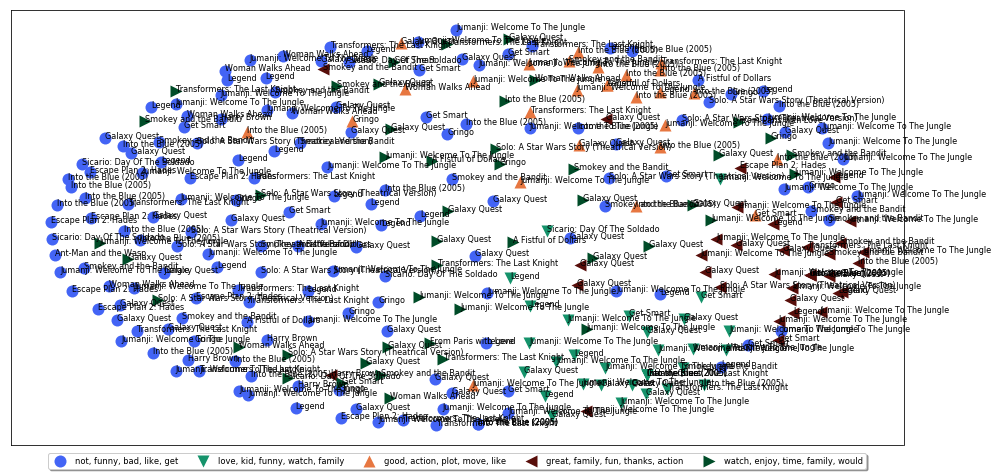

CPU times: user 7.22 s, sys: 351 ms, total: 7.57 s
Wall time: 4.97 s


In [591]:
%%time
# visualize the clusters
k5 = plot_clusters(num_clusters=num_clusters,
              feature_matrix=feature_matrix,
                cluster_data=cluster_data,
                movie_data=movie_data,
                plot_size=(16,8))
k5 

## K-means Clustering With Number of Clusters = 3


In [592]:
## Change 
# set k = 3, lets say we want 3 clusters from all movies
num_clusters = 3 # 5 
# get clusters and assigned the cluster labels to the movies
km_obj, clusters = k_means(feature_matrix=feature_matrix,
                           num_clusters=num_clusters)
movie_data['Cluster'] = clusters

In [593]:
# See the total number of movies for each of the 3 clusters
from collections import Counter
# get the total number of movies per cluster
c = Counter(clusters)
print c.items()


[(0, 221), (1, 29), (2, 50)]


In [594]:
# detailed analysis results for k-means clustering:
# get clustering analysis data
cluster_data =  get_cluster_data(clustering_obj=km_obj, movie_data=movie_data,
                                 feature_names=feature_names, num_clusters=num_clusters,
                                 topn_features=5)

In [595]:
# print clustering analysis results
print_cluster_data(cluster_data)

Cluster 0 details:
--------------------
Key features: [u'not', u'good', u'watch', u'time', u'funny']
Movies in this cluster:
['Galaxy Quest', 'Galaxy Quest', 'Woman Walks Ahead', 'Smokey and the Bandit', 'Galaxy Quest', 'Jumanji: Welcome To The Jungle', 'Escape Plan 2: Hades', 'Into the Blue (2005)', 'Into the Blue (2005)', 'Jumanji: Welcome To The Jungle', 'Jumanji: Welcome To The Jungle', 'Solo: A Star Wars Story (Theatrical Version)', 'Harry Brown', 'Into the Blue (2005)', 'Legend', 'Escape Plan 2: Hades', 'Jumanji: Welcome To The Jungle', 'Galaxy Quest', 'Jumanji: Welcome To The Jungle', 'Jumanji: Welcome To The Jungle', 'Legend', 'Escape Plan 2: Hades', 'Jumanji: Welcome To The Jungle', 'Legend', 'Smokey and the Bandit', 'Into the Blue (2005)', 'Get Smart', 'Harry Brown', 'Into the Blue (2005)', 'Into the Blue (2005)', 'Into the Blue (2005)', 'Transformers: The Last Knight', 'Into the Blue (2005)', 'Woman Walks Ahead', 'Smokey and the Bandit', 'Woman Walks Ahead', 'Get Smart', 'Es

/Users/heidinguyen/anaconda2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/heidinguyen/anaconda2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/heidinguyen/anaconda2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/heidinguyen/anaconda2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecation

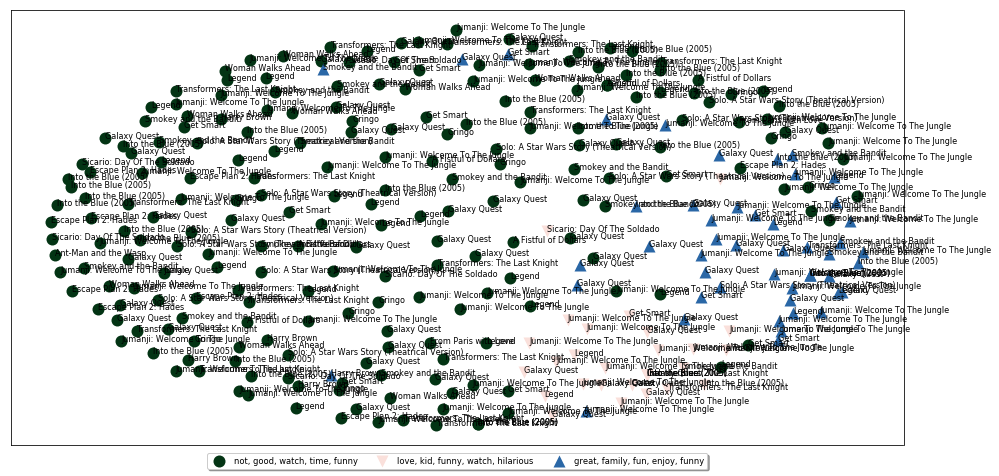

CPU times: user 7.86 s, sys: 412 ms, total: 8.28 s
Wall time: 5.56 s


In [596]:
%%time
# visualize the clusters
k3 = plot_clusters(num_clusters=num_clusters,
              feature_matrix=feature_matrix,
                cluster_data=cluster_data,
                movie_data=movie_data,
                plot_size=(16,8))
k3

## For each of the clusters, compute the average, median, high, and low sentiment scores for each cluster. Explain whether you think this reveals anything interesting about the clusters.

In [597]:
# 3 clusters 
# look at the data with cluster label
movie_data[:20] 


,title,reviews,Cluster
570,Jumanji: Welcome To The Jungle,"both my kids love this movie, it's pretty funn...",1
3302,Galaxy Quest,I liked this movie and I thought it would be l...,0
14020,Galaxy Quest,Ranks up there as one of the best Sci Fi movie...,0
7320,Woman Walks Ahead,"Not a bad film, but not an accurate one either...",0
7390,Into the Blue (2005),Loved the movie!,1
13280,Jumanji: Welcome To The Jungle,This movie is so entertaining and funny. My ki...,1
13293,Smokey and the Bandit,Always a good movie for a rainy day. Always lo...,0
11558,Galaxy Quest,this spoof of sify is a fun to watch and watch...,0
12245,Jumanji: Welcome To The Jungle,awesome perfect for everyone,0
10670,Legend,"great, thanks.",2


In [598]:
# Cluster 0, 1 and 2
cluster_0 = movie_data[movie_data['Cluster'] == 0] 
cluster_1 = movie_data[movie_data['Cluster'] == 1] 
cluster_2 = movie_data[movie_data['Cluster'] == 2] 
# look at some of the cluster 0, 1, and 2
print cluster_0.head()
print cluster_1.head()
print cluster_2.head()

                       title  \
3302            Galaxy Quest   
14020           Galaxy Quest   
7320       Woman Walks Ahead   
13293  Smokey and the Bandit   
11558           Galaxy Quest   

                                                 reviews  Cluster  
3302   I liked this movie and I thought it would be l...        0  
14020  Ranks up there as one of the best Sci Fi movie...        0  
7320   Not a bad film, but not an accurate one either...        0  
13293  Always a good movie for a rainy day. Always lo...        0  
11558  this spoof of sify is a fun to watch and watch...        0  
                                title  \
570    Jumanji: Welcome To The Jungle   
7390             Into the Blue (2005)   
13280  Jumanji: Welcome To The Jungle   
5284   Jumanji: Welcome To The Jungle   
8726    Transformers: The Last Knight   

                                                 reviews  Cluster  
570    both my kids love this movie, it's pretty funn...        1  
7390            

In [599]:
# get all the reviews in array
cluster_0_reviews = np.array(cluster_0['reviews'])
cluster_1_reviews = np.array(cluster_1['reviews'])
cluster_2_reviews = np.array(cluster_2['reviews'])

In [600]:
# all the sentiment score for each cluster
vader_cluster_0 = [analyze_sentiment_vader_lexicon(review, threshold=0.1) for review in cluster_0_reviews]
vader_cluster_1 = [analyze_sentiment_vader_lexicon(review, threshold=0.1) for review in cluster_1_reviews]
vader_cluster_2 = [analyze_sentiment_vader_lexicon(review, threshold=0.1) for review in cluster_2_reviews]

In [601]:
# all the sentiment score of cluster 0
vader_cluster_0

[-0.4215,
 0.6369,
 -0.0323,
 0.7777,
 0.7269,
 0.8316,
 -0.6249,
 0.4926,
 0.6369,
 0.7906,
 -0.3991,
 0.7818,
 -0.4404,
 0.0,
 0.0,
 -0.4767,
 0.0,
 0.0,
 0.7724,
 0.3818,
 0.0,
 0.0,
 0.8422,
 0.9198,
 0.4404,
 -0.5893,
 0.0,
 0.4957,
 0.4404,
 0.9313,
 0.4927,
 0.4404,
 0.4926,
 -0.079,
 0.8218,
 0.5487,
 0.8883,
 0.0258,
 0.6908,
 0.763,
 0.0,
 0.9231,
 0.1513,
 0.6461,
 0.0,
 0.9439,
 0.9564,
 0.4588,
 0.8952,
 0.9969,
 0.9827,
 0.9799,
 -0.7506,
 0.8689,
 0.0,
 -0.3412,
 0.4926,
 0.4404,
 -0.6369,
 0.9408,
 0.35,
 0.8338,
 0.9927,
 0.8172,
 0.5267,
 0.5719,
 0.7635,
 0.4939,
 0.5859,
 -0.6249,
 0.2425,
 0.9892,
 0.8439,
 0.4588,
 0.9451,
 -0.4302,
 -0.5423,
 0.9656,
 0.8176,
 0.9756,
 0.0382,
 0.3767,
 0.9719,
 -0.7937,
 0.5994,
 -0.3875,
 0.872,
 0.8399,
 0.4404,
 0.9957,
 -0.6669,
 -0.3182,
 0.8911,
 0.7892,
 0.9915,
 0.6039,
 0.7184,
 0.4404,
 0.7351,
 0.7269,
 0.4404,
 0.0,
 0.4541,
 -0.7783,
 -0.5423,
 0.9952,
 -0.3182,
 0.9721,
 0.0,
 -0.4666,
 -0.5106,
 0.0,
 0.5859,
 -0.

In [602]:
from scipy import stats

print "Cluster 0 statistic:"
print(stats.describe(vader_cluster_0))
# average, median, high, and low sentiment scores
print "median=",np.median(vader_cluster_0), "\n"

print "Cluster 1 statistic:" 
print(stats.describe(vader_cluster_1))
# average, median, high, and low sentiment scores
print "median=",np.median(vader_cluster_1), "\n"

print "Cluster 2 statistic:" 
print(stats.describe(vader_cluster_2))
# average, median, high, and low sentiment scores
print "median=",np.median(vader_cluster_2)


Cluster 0 statistic:
DescribeResult(nobs=221, minmax=(-0.9699, 0.9969), mean=0.38134389140271485, variance=0.3049545209284245, skewness=-0.8533383446549379, kurtosis=-0.45956410087311017)
median= 0.5413 

Cluster 1 statistic:
DescribeResult(nobs=29, minmax=(-0.5661, 0.9648), mean=0.7330068965517241, variance=0.07479329709359607, skewness=-3.804721507427369, kurtosis=15.912513557292382)
median= 0.784 

Cluster 2 statistic:
DescribeResult(nobs=50, minmax=(-0.8887, 0.9839), mean=0.669082, variance=0.13666612966938774, skewness=-2.949990821098258, kurtosis=9.655608371979318)
median= 0.7642


<a id="resultHW8"></a>

# Question 1 and 2: Summary of the Results: 

  1. In Python, load one of the sentiment vocabularies referenced in the textbook, and run the sentiment analyzer as explained in the corresponding reference. Add words to the sentiment vocabulary, if you think you need to, to better fit your particular text collection.
  
  ==> I use VADER lexicon as the sentiment analyzer. I also modified the stop word list to include 'action', 'minute', and 'Hollywood'. Since all my movies are action and adventure movies, the word "action" does not contribute much to my analysis. 
  
  2. For each of the clusters you created in homework 7, compute the average, median, high, and low sentiment scores for each cluster. Explain whether you think this reveals anything interesting about the clusters.
  
    ==> After cluster with k=3, I computed the mean, median, high, and low sentiment scores for each cluster. The results are of following: 
    
    Cluster 0 statistic:
    DescribeResult(nobs=221, minmax=(-0.9699, 0.9969), mean=0.38134389140271485, variance=0.3049545209284245, skewness=-0.8533383446549379, kurtosis=-0.45956410087311017)
    median= 0.5413 

    Cluster 1 statistic:
    DescribeResult(nobs=29, minmax=(-0.5661, 0.9648), mean=0.7330068965517241, variance=0.07479329709359607, skewness=-3.804721507427369, kurtosis=15.912513557292382)
    median= 0.784 

    Cluster 2 statistic:
    DescribeResult(nobs=50, minmax=(-0.8887, 0.9839), mean=0.669082, variance=0.13666612966938774, skewness=-2.949990821098258, kurtosis=9.655608371979318)
    median= 0.7642

  
This result seems to be consistent with the cluster key features. Cluster 0 has lowest mean and median. This suggests that cluster 0 seem to have the most "not so good" reviews. This is shown in the top key features of cluster 0, which includes the word "not". 

Cluster 1 has the highest mean and median, suggests that it has mostly positive reviews. The top key features of this cluster are mostly positive ( 'love', 'kid', 'funny', 'watch', 'hilarious'). This group of movies seems to be kid appropriate. 

Cluster 2 has high mean and median, also suggests that it has mostly positive reviews. The top key features of this cluster are also mostly positive ( u'great', u'family', u'fun', u'enjoy', u'funny'). This also seems to be family kind of movies group. 



 <a href="#top">Back to top</a>

In [603]:
# print clustering analysis results
print_cluster_data(cluster_data)

Cluster 0 details:
--------------------
Key features: [u'not', u'good', u'watch', u'time', u'funny']
Movies in this cluster:
['Galaxy Quest', 'Galaxy Quest', 'Woman Walks Ahead', 'Smokey and the Bandit', 'Galaxy Quest', 'Jumanji: Welcome To The Jungle', 'Escape Plan 2: Hades', 'Into the Blue (2005)', 'Into the Blue (2005)', 'Jumanji: Welcome To The Jungle', 'Jumanji: Welcome To The Jungle', 'Solo: A Star Wars Story (Theatrical Version)', 'Harry Brown', 'Into the Blue (2005)', 'Legend', 'Escape Plan 2: Hades', 'Jumanji: Welcome To The Jungle', 'Galaxy Quest', 'Jumanji: Welcome To The Jungle', 'Jumanji: Welcome To The Jungle', 'Legend', 'Escape Plan 2: Hades', 'Jumanji: Welcome To The Jungle', 'Legend', 'Smokey and the Bandit', 'Into the Blue (2005)', 'Get Smart', 'Harry Brown', 'Into the Blue (2005)', 'Into the Blue (2005)', 'Into the Blue (2005)', 'Transformers: The Last Knight', 'Into the Blue (2005)', 'Woman Walks Ahead', 'Smokey and the Bandit', 'Woman Walks Ahead', 'Get Smart', 'Es

<a id="ref"></a>
### Reference: 
    1. http://blog.conceptnet.io/posts/2012/fixing-common-unicode-mistakes-with-python-after-theyve-been-made/


 <a href="#top">Back to top</a>